<a href="https://colab.research.google.com/github/kevintsi/deep_learning_course/blob/main/project_dl_covid_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Deep Learning : Détection de COVID

## Problématique

Le but de ce projet de Deeplearning est de pouvoir identifier, à l'aide de radiographie de poumons si les poumons sont infectés par le COVID ou non. 

Ce modèle pourrait être utilisé à usage médical pour pouvoir identifier les patients étant infecté par le COVID.

Dataset : https://drive.google.com/drive/folders/13q2ppJmOtz1rXrvLhYP0F0HkTVfAlyjp?usp=sharing

In [ ]:
# Installation des dépendances pour installer FastAI
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
# Import des librairies de FastAI
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# Initialisation du chemin vers les données
Ntrain = 400
Nval = 200

covid_sample_path = f"drive/MyDrive/covid_detection_sample_{Ntrain}_Ntrain_{Nval}_Nval"

In [ ]:
# Initialisation de la liste des types possibles (COVID ou Normal)
state_types = ["COVID", "Normal"] 

In [ ]:
# Récupérer les images du drive
fns = get_image_files(covid_sample_path+"/train")
fns

(#200) [Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-1.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-15.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-4.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-5.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-2.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-13.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-8.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-9.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-16.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-14.png')...]

In [ ]:
states = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Initialisation d'un DataBlock avec comme cible une catégorie (CategoryBlock) et comme feature une image (ImageBlock)
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Le splitter (RandomSplitter) permettant de diviser les données en 2 parties (test, train)
    get_y=parent_label)

In [ ]:
dls = states.dataloaders(covid_sample_path+"/train") # Creation du dataloaders

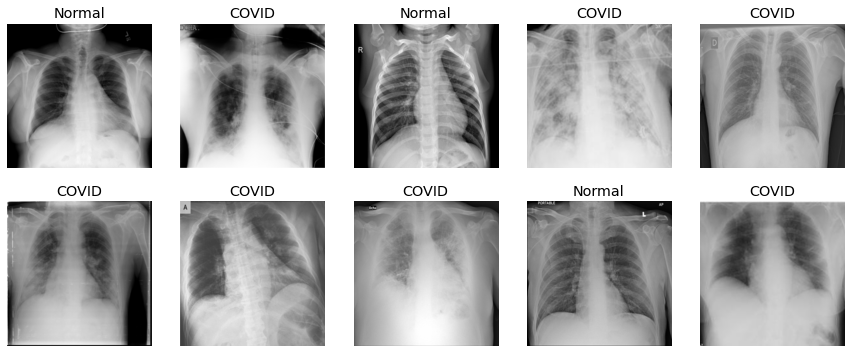

In [ ]:
dls.valid.show_batch(max_n=10, nrows=2) # Affichage des batchs

## Data augmentation

Dans la partie suivante, nous allons faire de la data augmentation, ce qui signifie qu'on va "tordre", modifier les images pour augmenter la généralisation (rajouter du biais)

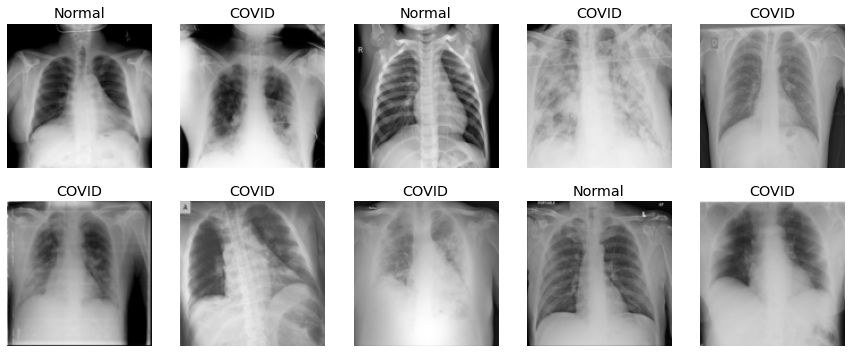

In [ ]:
states = states.new(item_tfms=Resize(128, ResizeMethod.Squish)) # Dans cette étape on va écraser les images
dls = states.dataloaders(covid_sample_path+"/train")
dls.valid.show_batch(max_n=10, nrows=2)

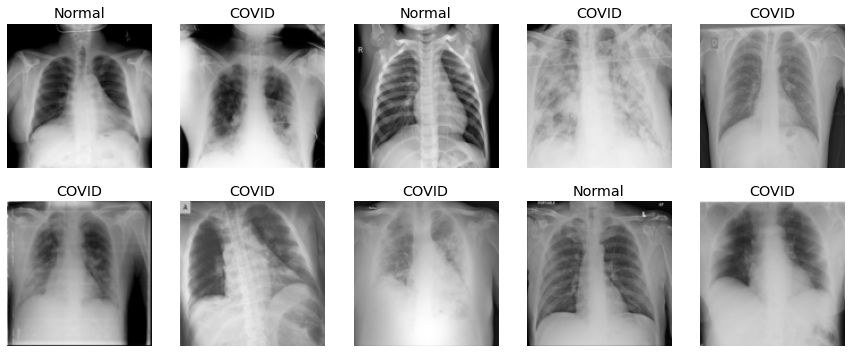

In [ ]:
states = states.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
dls = states.dataloaders(covid_sample_path+"/train")
dls.valid.show_batch(max_n=10, nrows=2)

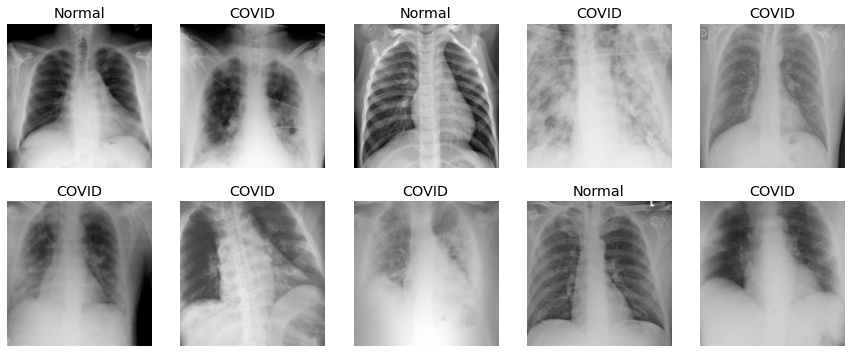

In [ ]:
states = states.new(item_tfms=RandomResizedCrop(175, min_scale=0.3)) # Dans cette étape on va zoomer dans les images
dls = states.dataloaders(covid_sample_path+"/train")
dls.valid.show_batch(max_n=10, nrows=2)

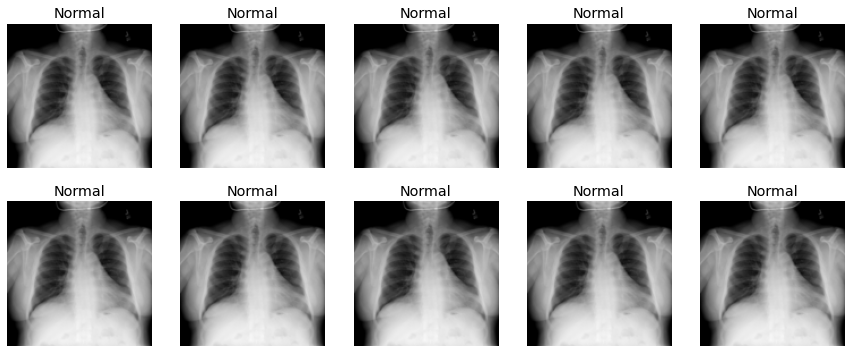

In [ ]:
states = states.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = states.dataloaders(covid_sample_path+"/train")
dls.valid.show_batch(max_n=10, nrows=2, unique=True)

In [ ]:
states = states.new(item_tfms=RandomResizedCrop(275, min_scale=0.6), batch_tfms=aug_transforms())
dls = states.dataloaders(covid_sample_path+"/train")

## Entrainement

Dans cette partie, nous allons entrainer le modèle pour augmenter sa précision et par conséquent diminuer son taux d'erreur

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.356564,0.908123,0.475000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.261142,0.717597,0.350000,00:04
1,0.978844,0.597556,0.350000,00:04
2,0.931413,0.610608,0.250000,00:04
3,0.788002,0.578855,0.250000,00:04
4,0.734839,0.461536,0.250000,00:04
5,0.681511,0.378474,0.175000,00:04
6,0.624056,0.316943,0.125000,00:04
7,0.588655,0.280473,0.125000,00:04
8,0.544940,0.259179,0.100000,00:04
9,0.509763,0.255940,0.075000,00:04


On peut voir qu'au bout de 10 epochs on a réussi à passer le taux d'erreur de 35 % à environ 7 %

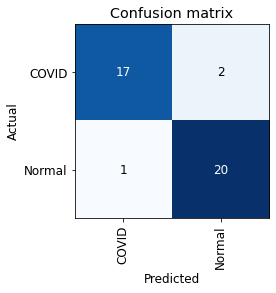

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Grâce à la matrice de confusion nous pouvons voir que notre modèle n'est pas overfitté mais est plutôt acceptable

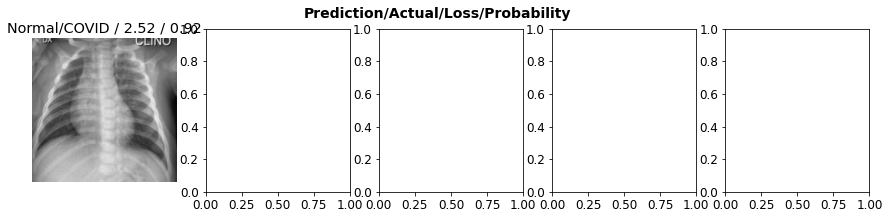

In [ ]:
interp.plot_top_losses(5, nrows=1) # Permet de regarder le top 5 des radiographie qui ont le plus de perte

Je n'ai pas fait de cleanage de données car il m'était difficile de faire la différence entre un poumon atteint du COVID et un qui ne l'est pas

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Exportation du modèle

In [ ]:
learn.export(fname=covid_sample_path+"/model.pkl") # Exportation du modèle en format .pkl dans le chemin covid_sample_path

In [ ]:
path = Path(covid_sample_path) # Créer une instance Path contenant le chemin vers le dossier covid_detection_sample_400_Ntrain_200_Nval
path

Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval')

In [ ]:
path.ls(file_exts='.pkl') # Fait un ls sur le chemin donnée précédent en ne prenant que les fichiers .pkl pour vérifier si le modèle a bien été créer correctement 

(#1) [Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/model.pkl')]

In [ ]:
learn_inf = load_learner(path/'model.pkl') # Charge le modèle

In [ ]:
learn_inf.dls.vocab

['COVID', 'Normal']

## Test du modèle généré 

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Normal; Probability: 0.9988')